In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


import keras_tuner as kt
from GraphTransformerPrerocessAll import graph_global_transformer_local_process
from graph import graph_topology_5
from models.graph_global_transformer_local import graph_global_transformer_local

2023-07-22 01:19:36.786440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 01:19:38.746339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
embed_feat=4
head_size = 48*2
num_heads = 3
ff_dim = 48
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 0
l2_reg = 1e-4
gcn_unit1 = 48
gcn_unit2 = 32
gcn_unit3 = 16
lstm_units = 32
learning_rate = 1e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_26, val_26, test_26, \
train_25B, val_25B, test_25B, \
train_25A, val_25A, test_25A, \
train_1, val_1, test_1, \
train_4, val_4, test_4, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_global_transformer_local_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_26.shape, val_26.shape, test_26.shape, 
      train_25B.shape, val_25B.shape, test_25B.shape, 
      train_25A.shape, val_25A.shape, test_25A.shape, 
      train_1.shape, val_1.shape, test_1.shape, 
      train_4.shape, val_4.shape, test_4.shape, 
      train_ws_y.shape, val_ws_y.shape, test_ws_y.shape
     )

(77069, 96, 7) (9634, 96, 7) (19268, 96, 7) (77069, 96, 7) (9634, 96, 7) (19268, 96, 7) (77069, 96, 5) (9634, 96, 5) (19268, 96, 5) (77069, 96, 2) (9634, 96, 2) (19268, 96, 2) (77069, 96, 2) (9634, 96, 2) (19268, 96, 2) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_26, val_26, test_26 = train_26[:, :n_hours, :], val_26[:, :n_hours, :], test_26[:, :n_hours, :]
train_25B, val_25B, test_25B = train_25B[:, :n_hours, :], val_25B[:, :n_hours, :], test_25B[:, :n_hours, :]
train_25A, val_25A, test_25A = train_25A[:, :n_hours, :], val_25A[:, :n_hours, :], test_25A[:, :n_hours, :]
train_1, val_1, test_1 = train_1[:, :n_hours, :], val_1[:, :n_hours, :], test_1[:, :n_hours, :]
train_4, val_4, test_4 = train_4[:, :n_hours, :], val_4[:, :n_hours, :], test_4[:, :n_hours, :]

In [7]:
print(train_26.shape, val_26.shape, test_26.shape, 
      train_25B.shape, val_25B.shape, test_25B.shape, 
      train_25A.shape, val_25A.shape, test_25A.shape, 
      train_1.shape, val_1.shape, test_1.shape, 
      train_4.shape, val_4.shape, test_4.shape, 
      train_ws_y.shape, val_ws_y.shape, test_ws_y.shape
     )

(77069, 72, 7) (9634, 72, 7) (19268, 72, 7) (77069, 72, 7) (9634, 72, 7) (19268, 72, 7) (77069, 72, 5) (9634, 72, 5) (19268, 72, 5) (77069, 72, 2) (9634, 72, 2) (19268, 72, 2) (77069, 72, 2) (9634, 72, 2) (19268, 72, 2) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [8]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [9]:
S26_shape = (train_26.shape[1], train_26.shape[2])
S25B_shape = (train_25B.shape[1], train_25B.shape[2])
S25A_shape = (train_25A.shape[1], train_25A.shape[2])
S1_shape = (train_1.shape[1], train_1.shape[2])
S4_shape = (train_4.shape[1], train_4.shape[2])

In [10]:
model, GCNConv = graph_global_transformer_local(gcn1=gcn_unit1,
                                                gcn2=gcn_unit2,
                                                gcn3=gcn_unit3,
                                                lstm_unit=lstm_units, 
                                                num_transformer_blocks=num_transformer_blocks,
                                                head_size=head_size,
                                                num_heads=num_heads,
                                                ff_dim=ff_dim, 
                                                atte_reg=atte_reg, 
                                                l1_reg=l1_reg, 
                                                l2_reg=l2_reg, 
                                                dropout=dropout,
                                                masked_value=masked_value,
                                                embed_feat=embed_feat,
                                                S26_shape=S26_shape, 
                                                S25B_shape=S25B_shape, 
                                                S25A_shape=S25A_shape, 
                                                S1_shape=S1_shape,
                                                S4_shape=S4_shape
                                               )
model.summary()

2023-07-22 01:19:55.149661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 7)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 72, 7)]              0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 72, 5)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 72, 2)]              0         []                            
                                                                                              

                                                                                                  
 conv1d (Conv1D)             (None, 72, 48)               720       ['layer_normalization[0][0]'] 
                                                                                                  
 conv1d_3 (Conv1D)           (None, 72, 48)               720       ['layer_normalization_2[0][0]'
                                                                    ]                             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 72, 48)               528       ['layer_normalization_4[0][0]'
                                                                    ]                             
                                                                                                  
 conv1d_9 (Conv1D)           (None, 72, 48)               240       ['layer_normalization_6[0][0]'
          

                                                                    ']                            
                                                                                                  
 concat_local (Concatenate)  (None, 72, 20)               0         ['conv1d_2[0][0]',            
                                                                     'conv1d_5[0][0]',            
                                                                     'conv1d_8[0][0]',            
                                                                     'conv1d_11[0][0]',           
                                                                     'conv1d_14[0][0]']           
                                                                                                  
 reshape_global (Reshape)    (None, 5, 288)               0         ['concat_local[0][0]']        
                                                                                                  
 input_lap

In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/graph_global_transformer_local_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_26, train_25B, train_25A, train_1, train_4, train_adj_mat], train_ws_y,
           validation_data=([test_26, test_25B, test_25A, test_1, test_4, test_adj_mat], test_ws_y),
           epochs=EPOCHS,
           batch_size=BATCH,
           verbose=2,
           shuffle=True,
           callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 01:20:35.631029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 01:20:36.848792: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdef800e100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 01:20:36.848871: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 01:20:36.861941: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 01:20:37.225317: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.14702, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 - 53s - loss: 0.6417 - mae: 0.1508 - val_loss: 0.2147 - val_mae: 0.1470 - 53s/epoch - 349ms/step
Epoch 2/3000

Epoch 2: val_mae improved from 0.14702 to 0.06703, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 0.1102 - mae: 0.0654 - val_loss: 0.0652 - val_mae: 0.0670 - 17s/epoch - 110ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.06703 to 0.05768, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 0.0453 - mae: 0.0423 - val_loss: 0.0371 - val_mae: 0.0577 - 17s/epoch - 111ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05768 to 0.05276, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 0.0293 - mae: 0.0377 - val_loss: 0.0278 - val_mae: 0.0528 - 17s/epoch - 110ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05276 to 0.05017, saving model to saved_models/graph_global_transformer_local_gate_pump_nofu

151/151 - 16s - loss: 0.0046 - mae: 0.0206 - val_loss: 0.0059 - val_mae: 0.0373 - 16s/epoch - 107ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.03597
151/151 - 16s - loss: 0.0044 - mae: 0.0204 - val_loss: 0.0055 - val_mae: 0.0362 - 16s/epoch - 108ms/step
Epoch 43/3000

Epoch 43: val_mae did not improve from 0.03597
151/151 - 16s - loss: 0.0041 - mae: 0.0203 - val_loss: 0.0053 - val_mae: 0.0362 - 16s/epoch - 108ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.03597 to 0.03590, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 0.0039 - mae: 0.0201 - val_loss: 0.0050 - val_mae: 0.0359 - 17s/epoch - 111ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.03590
151/151 - 16s - loss: 0.0037 - mae: 0.0201 - val_loss: 0.0048 - val_mae: 0.0361 - 16s/epoch - 108ms/step
Epoch 46/3000

Epoch 46: val_mae improved from 0.03590 to 0.03535, saving model to saved_models/graph_global_transformer_local_gate_pump_nof

Epoch 87/3000

Epoch 87: val_mae did not improve from 0.03341
151/151 - 16s - loss: 7.9471e-04 - mae: 0.0182 - val_loss: 0.0022 - val_mae: 0.0356 - 16s/epoch - 107ms/step
Epoch 88/3000

Epoch 88: val_mae did not improve from 0.03341
151/151 - 16s - loss: 7.9104e-04 - mae: 0.0182 - val_loss: 0.0021 - val_mae: 0.0346 - 16s/epoch - 107ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.03341
151/151 - 16s - loss: 7.8600e-04 - mae: 0.0182 - val_loss: 0.0023 - val_mae: 0.0363 - 16s/epoch - 107ms/step
Epoch 90/3000

Epoch 90: val_mae did not improve from 0.03341
151/151 - 16s - loss: 7.8160e-04 - mae: 0.0182 - val_loss: 0.0020 - val_mae: 0.0341 - 16s/epoch - 107ms/step
Epoch 91/3000

Epoch 91: val_mae did not improve from 0.03341
151/151 - 16s - loss: 7.7783e-04 - mae: 0.0182 - val_loss: 0.0021 - val_mae: 0.0349 - 16s/epoch - 107ms/step
Epoch 92/3000

Epoch 92: val_mae did not improve from 0.03341
151/151 - 16s - loss: 7.7456e-04 - mae: 0.0182 - val_loss: 0.0021 - val_mae: 0.0346

Epoch 133/3000

Epoch 133: val_mae improved from 0.03203 to 0.03200, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 6.8869e-04 - mae: 0.0177 - val_loss: 0.0017 - val_mae: 0.0320 - 17s/epoch - 110ms/step
Epoch 134/3000

Epoch 134: val_mae did not improve from 0.03200
151/151 - 16s - loss: 6.9122e-04 - mae: 0.0177 - val_loss: 0.0019 - val_mae: 0.0337 - 16s/epoch - 107ms/step
Epoch 135/3000

Epoch 135: val_mae did not improve from 0.03200
151/151 - 16s - loss: 7.0447e-04 - mae: 0.0180 - val_loss: 0.0018 - val_mae: 0.0326 - 16s/epoch - 107ms/step
Epoch 136/3000

Epoch 136: val_mae did not improve from 0.03200
151/151 - 16s - loss: 6.9123e-04 - mae: 0.0178 - val_loss: 0.0018 - val_mae: 0.0326 - 16s/epoch - 107ms/step
Epoch 137/3000

Epoch 137: val_mae did not improve from 0.03200
151/151 - 16s - loss: 6.8540e-04 - mae: 0.0177 - val_loss: 0.0017 - val_mae: 0.0320 - 16s/epoch - 108ms/step
Epoch 138/3000

Epoch 138: val_mae did not impro

Epoch 178/3000

Epoch 178: val_mae did not improve from 0.03071
151/151 - 16s - loss: 6.4454e-04 - mae: 0.0174 - val_loss: 0.0018 - val_mae: 0.0322 - 16s/epoch - 107ms/step
Epoch 179/3000

Epoch 179: val_mae improved from 0.03071 to 0.03062, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 16s - loss: 6.4995e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0306 - 16s/epoch - 109ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.03062
151/151 - 16s - loss: 6.5074e-04 - mae: 0.0175 - val_loss: 0.0017 - val_mae: 0.0315 - 16s/epoch - 107ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.03062
151/151 - 16s - loss: 6.3855e-04 - mae: 0.0173 - val_loss: 0.0017 - val_mae: 0.0312 - 16s/epoch - 107ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.03062
151/151 - 16s - loss: 6.4786e-04 - mae: 0.0175 - val_loss: 0.0018 - val_mae: 0.0320 - 16s/epoch - 107ms/step
Epoch 183/3000

Epoch 183: val_mae did not impro

Epoch 224/3000

Epoch 224: val_mae did not improve from 0.02984
151/151 - 16s - loss: 6.2183e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0301 - 16s/epoch - 107ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.02984
151/151 - 16s - loss: 6.3292e-04 - mae: 0.0175 - val_loss: 0.0017 - val_mae: 0.0313 - 16s/epoch - 107ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.02984
151/151 - 16s - loss: 6.1728e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0304 - 16s/epoch - 108ms/step
Epoch 227/3000

Epoch 227: val_mae improved from 0.02984 to 0.02976, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 6.2330e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0298 - 17s/epoch - 110ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.02976
151/151 - 16s - loss: 6.1975e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0310 - 16s/epoch - 108ms/step
Epoch 229/3000

Epoch 229: val_mae did not impro

151/151 - 16s - loss: 6.0355e-04 - mae: 0.0171 - val_loss: 0.0015 - val_mae: 0.0295 - 16s/epoch - 107ms/step
Epoch 270/3000

Epoch 270: val_mae did not improve from 0.02898
151/151 - 16s - loss: 6.0904e-04 - mae: 0.0172 - val_loss: 0.0015 - val_mae: 0.0291 - 16s/epoch - 108ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.02898
151/151 - 16s - loss: 6.0130e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0300 - 16s/epoch - 107ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.02898
151/151 - 16s - loss: 5.9925e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0292 - 16s/epoch - 107ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.02898
151/151 - 16s - loss: 6.0699e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0313 - 16s/epoch - 108ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.02898
151/151 - 16s - loss: 6.0235e-04 - mae: 0.0171 - val_loss: 0.0015 - val_mae: 0.0294 - 16s/epoch - 108ms/step
Epoch 275/3000

Epoch 275:

151/151 - 17s - loss: 5.9455e-04 - mae: 0.0170 - val_loss: 0.0014 - val_mae: 0.0283 - 17s/epoch - 110ms/step
Epoch 316/3000

Epoch 316: val_mae did not improve from 0.02834
151/151 - 16s - loss: 5.9065e-04 - mae: 0.0169 - val_loss: 0.0017 - val_mae: 0.0311 - 16s/epoch - 107ms/step
Epoch 317/3000

Epoch 317: val_mae did not improve from 0.02834
151/151 - 16s - loss: 5.9962e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0302 - 16s/epoch - 107ms/step
Epoch 318/3000

Epoch 318: val_mae did not improve from 0.02834
151/151 - 16s - loss: 5.9298e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0296 - 16s/epoch - 108ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.02834
151/151 - 16s - loss: 5.9464e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0294 - 16s/epoch - 108ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.02834
151/151 - 16s - loss: 5.9198e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0313 - 16s/epoch - 107ms/step
Epoch 321/3000

Epoch 321:

Epoch 362/3000

Epoch 362: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.9055e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0292 - 16s/epoch - 108ms/step
Epoch 363/3000

Epoch 363: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8326e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 107ms/step
Epoch 364/3000

Epoch 364: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8378e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0293 - 16s/epoch - 108ms/step
Epoch 365/3000

Epoch 365: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8502e-04 - mae: 0.0169 - val_loss: 0.0017 - val_mae: 0.0309 - 16s/epoch - 108ms/step
Epoch 366/3000

Epoch 366: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8970e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0288 - 16s/epoch - 108ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8698e-04 - mae: 0.0169 - val_loss: 0.0015 - val

151/151 - 16s - loss: 5.7627e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0302 - 16s/epoch - 108ms/step
Epoch 410/3000

Epoch 410: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.7692e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0299 - 16s/epoch - 107ms/step
Epoch 411/3000

Epoch 411: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8419e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0290 - 16s/epoch - 107ms/step
Epoch 412/3000

Epoch 412: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.7960e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 108ms/step
Epoch 413/3000

Epoch 413: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.8689e-04 - mae: 0.0170 - val_loss: 0.0017 - val_mae: 0.0309 - 16s/epoch - 108ms/step
Epoch 414/3000

Epoch 414: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.7829e-04 - mae: 0.0168 - val_loss: 0.0017 - val_mae: 0.0303 - 16s/epoch - 108ms/step
Epoch 415/3000

Epoch 415:

Epoch 457/3000

Epoch 457: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.7581e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0294 - 16s/epoch - 107ms/step
Epoch 458/3000

Epoch 458: val_mae did not improve from 0.02806
151/151 - 16s - loss: 5.7138e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0302 - 16s/epoch - 108ms/step
Epoch 459/3000

Epoch 459: val_mae improved from 0.02806 to 0.02803, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 17s - loss: 5.8044e-04 - mae: 0.0169 - val_loss: 0.0014 - val_mae: 0.0280 - 17s/epoch - 110ms/step
Epoch 460/3000

Epoch 460: val_mae did not improve from 0.02803
151/151 - 16s - loss: 5.7448e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0288 - 16s/epoch - 108ms/step
Epoch 461/3000

Epoch 461: val_mae did not improve from 0.02803
151/151 - 16s - loss: 5.7486e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0289 - 16s/epoch - 107ms/step
Epoch 462/3000

Epoch 462: val_mae did not impro

151/151 - 16s - loss: 5.6903e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0300 - 16s/epoch - 108ms/step
Epoch 504/3000

Epoch 504: val_mae did not improve from 0.02788
151/151 - 16s - loss: 5.6783e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0313 - 16s/epoch - 107ms/step
Epoch 505/3000

Epoch 505: val_mae did not improve from 0.02788
151/151 - 16s - loss: 5.7468e-04 - mae: 0.0168 - val_loss: 0.0017 - val_mae: 0.0311 - 16s/epoch - 108ms/step
Epoch 506/3000

Epoch 506: val_mae did not improve from 0.02788
151/151 - 16s - loss: 5.6778e-04 - mae: 0.0167 - val_loss: 0.0014 - val_mae: 0.0283 - 16s/epoch - 107ms/step
Epoch 507/3000

Epoch 507: val_mae did not improve from 0.02788
151/151 - 16s - loss: 5.7193e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0297 - 16s/epoch - 108ms/step
Epoch 508/3000

Epoch 508: val_mae did not improve from 0.02788
151/151 - 16s - loss: 5.6524e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0290 - 16s/epoch - 108ms/step
Epoch 509/3000

Epoch 509:

Epoch 550/3000

Epoch 550: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5740e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0287 - 16s/epoch - 108ms/step
Epoch 551/3000

Epoch 551: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6215e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0296 - 16s/epoch - 107ms/step
Epoch 552/3000

Epoch 552: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6401e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0293 - 16s/epoch - 108ms/step
Epoch 553/3000

Epoch 553: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6121e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0295 - 16s/epoch - 107ms/step
Epoch 554/3000

Epoch 554: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6332e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0296 - 16s/epoch - 108ms/step
Epoch 555/3000

Epoch 555: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6463e-04 - mae: 0.0166 - val_loss: 0.0015 - val

151/151 - 16s - loss: 5.5546e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0290 - 16s/epoch - 108ms/step
Epoch 598/3000

Epoch 598: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6413e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0299 - 16s/epoch - 107ms/step
Epoch 599/3000

Epoch 599: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5819e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 108ms/step
Epoch 600/3000

Epoch 600: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5892e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 108ms/step
Epoch 601/3000

Epoch 601: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.6006e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0291 - 16s/epoch - 107ms/step
Epoch 602/3000

Epoch 602: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5639e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0284 - 16s/epoch - 107ms/step
Epoch 603/3000

Epoch 603:

Epoch 645/3000

Epoch 645: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5746e-04 - mae: 0.0165 - val_loss: 0.0016 - val_mae: 0.0294 - 16s/epoch - 107ms/step
Epoch 646/3000

Epoch 646: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5812e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0299 - 16s/epoch - 107ms/step
Epoch 647/3000

Epoch 647: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5261e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 107ms/step
Epoch 648/3000

Epoch 648: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5974e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0285 - 16s/epoch - 107ms/step
Epoch 649/3000

Epoch 649: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5327e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0289 - 16s/epoch - 107ms/step
Epoch 650/3000

Epoch 650: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5290e-04 - mae: 0.0165 - val_loss: 0.0014 - val

151/151 - 16s - loss: 5.5104e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0289 - 16s/epoch - 108ms/step
Epoch 693/3000

Epoch 693: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5326e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 107ms/step
Epoch 694/3000

Epoch 694: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5623e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0287 - 16s/epoch - 107ms/step
Epoch 695/3000

Epoch 695: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5150e-04 - mae: 0.0165 - val_loss: 0.0016 - val_mae: 0.0297 - 16s/epoch - 107ms/step
Epoch 696/3000

Epoch 696: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5505e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0291 - 16s/epoch - 107ms/step
Epoch 697/3000

Epoch 697: val_mae did not improve from 0.02768
151/151 - 16s - loss: 5.5139e-04 - mae: 0.0164 - val_loss: 0.0016 - val_mae: 0.0296 - 16s/epoch - 108ms/step
Epoch 698/3000

Epoch 698:

151/151 - 16s - loss: 5.5249e-04 - mae: 0.0165 - val_loss: 0.0014 - val_mae: 0.0282 - 16s/epoch - 107ms/step
Epoch 740/3000

Epoch 740: val_mae did not improve from 0.02747
151/151 - 16s - loss: 5.4988e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 107ms/step
Epoch 741/3000

Epoch 741: val_mae did not improve from 0.02747
151/151 - 16s - loss: 5.4751e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0282 - 16s/epoch - 107ms/step
Epoch 742/3000

Epoch 742: val_mae did not improve from 0.02747
151/151 - 16s - loss: 5.4876e-04 - mae: 0.0164 - val_loss: 0.0016 - val_mae: 0.0290 - 16s/epoch - 107ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.02747
151/151 - 16s - loss: 5.4874e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 108ms/step
Epoch 744/3000

Epoch 744: val_mae did not improve from 0.02747
151/151 - 16s - loss: 5.5043e-04 - mae: 0.0165 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 108ms/step
Epoch 745/3000

Epoch 745:

Epoch 787/3000

Epoch 787: val_mae improved from 0.02747 to 0.02745, saving model to saved_models/graph_global_transformer_local_gate_pump_nofuture.h5
151/151 - 16s - loss: 5.4651e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 108ms/step
Epoch 788/3000

Epoch 788: val_mae did not improve from 0.02745
151/151 - 16s - loss: 5.5165e-04 - mae: 0.0165 - val_loss: 0.0016 - val_mae: 0.0295 - 16s/epoch - 106ms/step
Epoch 789/3000

Epoch 789: val_mae did not improve from 0.02745
151/151 - 16s - loss: 5.4746e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0281 - 16s/epoch - 106ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.02745
151/151 - 16s - loss: 5.4885e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0285 - 16s/epoch - 106ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.02745
151/151 - 16s - loss: 5.4769e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 792/3000

Epoch 792: val_mae did not impro

151/151 - 16s - loss: 5.4932e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0290 - 16s/epoch - 106ms/step
Epoch 834/3000

Epoch 834: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4777e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 835/3000

Epoch 835: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4459e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0287 - 16s/epoch - 106ms/step
Epoch 836/3000

Epoch 836: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4514e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 837/3000

Epoch 837: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4321e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0283 - 16s/epoch - 106ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.5388e-04 - mae: 0.0166 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 105ms/step
Epoch 839/3000

Epoch 839:

Epoch 881/3000

Epoch 881: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4663e-04 - mae: 0.0164 - val_loss: 0.0016 - val_mae: 0.0293 - 16s/epoch - 106ms/step
Epoch 882/3000

Epoch 882: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4224e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0288 - 16s/epoch - 106ms/step
Epoch 883/3000

Epoch 883: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4376e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0290 - 16s/epoch - 106ms/step
Epoch 884/3000

Epoch 884: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.3859e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0295 - 16s/epoch - 106ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.3854e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.02729
151/151 - 16s - loss: 5.4284e-04 - mae: 0.0163 - val_loss: 0.0014 - val

Epoch 928/3000

Epoch 928: val_mae did not improve from 0.02725
151/151 - 16s - loss: 5.3785e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0273 - 16s/epoch - 106ms/step
Epoch 929/3000

Epoch 929: val_mae did not improve from 0.02725
151/151 - 16s - loss: 5.4600e-04 - mae: 0.0164 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 930/3000

Epoch 930: val_mae did not improve from 0.02725
151/151 - 16s - loss: 5.3836e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0288 - 16s/epoch - 106ms/step
Epoch 931/3000

Epoch 931: val_mae did not improve from 0.02725
151/151 - 16s - loss: 5.3853e-04 - mae: 0.0163 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 932/3000

Epoch 932: val_mae did not improve from 0.02725
151/151 - 16s - loss: 5.4129e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0285 - 16s/epoch - 106ms/step
Epoch 933/3000

Epoch 933: val_mae did not improve from 0.02725
151/151 - 16s - loss: 5.3792e-04 - mae: 0.0162 - val_loss: 0.0015 - val

Epoch 975/3000

Epoch 975: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3728e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0290 - 16s/epoch - 106ms/step
Epoch 976/3000

Epoch 976: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3931e-04 - mae: 0.0163 - val_loss: 0.0014 - val_mae: 0.0280 - 16s/epoch - 106ms/step
Epoch 977/3000

Epoch 977: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3615e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0289 - 16s/epoch - 107ms/step
Epoch 978/3000

Epoch 978: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3932e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0281 - 16s/epoch - 106ms/step
Epoch 979/3000

Epoch 979: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3647e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 980/3000

Epoch 980: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3702e-04 - mae: 0.0162 - val_loss: 0.0014 - val

151/151 - 16s - loss: 5.3680e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1023/3000

Epoch 1023: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3360e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0289 - 16s/epoch - 106ms/step
Epoch 1024/3000

Epoch 1024: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3623e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0280 - 16s/epoch - 106ms/step
Epoch 1025/3000

Epoch 1025: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3531e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1026/3000

Epoch 1026: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3665e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 1027/3000

Epoch 1027: val_mae did not improve from 0.02712
151/151 - 16s - loss: 5.3666e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0280 - 16s/epoch - 106ms/step
Epoch 1028/3000


Epoch 1069/3000

Epoch 1069: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3533e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1070/3000

Epoch 1070: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3319e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 107ms/step
Epoch 1071/3000

Epoch 1071: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3433e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1072/3000

Epoch 1072: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3601e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1073/3000

Epoch 1073: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3087e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0276 - 16s/epoch - 106ms/step
Epoch 1074/3000

Epoch 1074: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3902e-04 - mae: 0.0163 - val_loss: 

Epoch 1116/3000

Epoch 1116: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3286e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0276 - 16s/epoch - 106ms/step
Epoch 1117/3000

Epoch 1117: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3513e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0283 - 16s/epoch - 106ms/step
Epoch 1118/3000

Epoch 1118: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3478e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 1119/3000

Epoch 1119: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3305e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1120/3000

Epoch 1120: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3148e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1121/3000

Epoch 1121: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3144e-04 - mae: 0.0161 - val_loss: 

Epoch 1163/3000

Epoch 1163: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3002e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1164/3000

Epoch 1164: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3270e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1165/3000

Epoch 1165: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3162e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1166/3000

Epoch 1166: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3136e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1167/3000

Epoch 1167: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3320e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1168/3000

Epoch 1168: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3214e-04 - mae: 0.0162 - val_loss: 

Epoch 1210/3000

Epoch 1210: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2798e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0276 - 16s/epoch - 106ms/step
Epoch 1211/3000

Epoch 1211: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3231e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0293 - 16s/epoch - 106ms/step
Epoch 1212/3000

Epoch 1212: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3242e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0287 - 16s/epoch - 106ms/step
Epoch 1213/3000

Epoch 1213: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2956e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1214/3000

Epoch 1214: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3081e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1215/3000

Epoch 1215: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3014e-04 - mae: 0.0161 - val_loss: 

Epoch 1257/3000

Epoch 1257: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2940e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1258/3000

Epoch 1258: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2618e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1259/3000

Epoch 1259: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3056e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0285 - 16s/epoch - 106ms/step
Epoch 1260/3000

Epoch 1260: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3209e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1261/3000

Epoch 1261: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2574e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1262/3000

Epoch 1262: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2762e-04 - mae: 0.0161 - val_loss: 

Epoch 1304/3000

Epoch 1304: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2534e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0273 - 16s/epoch - 106ms/step
Epoch 1305/3000

Epoch 1305: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2744e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0280 - 16s/epoch - 106ms/step
Epoch 1306/3000

Epoch 1306: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2675e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 1307/3000

Epoch 1307: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.3320e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1308/3000

Epoch 1308: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2584e-04 - mae: 0.0161 - val_loss: 0.0015 - val_mae: 0.0286 - 16s/epoch - 106ms/step
Epoch 1309/3000

Epoch 1309: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2595e-04 - mae: 0.0161 - val_loss: 

Epoch 1351/3000

Epoch 1351: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2502e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0276 - 16s/epoch - 106ms/step
Epoch 1352/3000

Epoch 1352: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2556e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1353/3000

Epoch 1353: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2401e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1354/3000

Epoch 1354: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2583e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1355/3000

Epoch 1355: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2580e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0271 - 16s/epoch - 106ms/step
Epoch 1356/3000

Epoch 1356: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2463e-04 - mae: 0.0160 - val_loss: 

Epoch 1398/3000

Epoch 1398: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2647e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1399/3000

Epoch 1399: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2407e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0274 - 16s/epoch - 106ms/step
Epoch 1400/3000

Epoch 1400: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2606e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0283 - 16s/epoch - 106ms/step
Epoch 1401/3000

Epoch 1401: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2348e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1402/3000

Epoch 1402: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2481e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 105ms/step
Epoch 1403/3000

Epoch 1403: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2326e-04 - mae: 0.0160 - val_loss: 

Epoch 1445/3000

Epoch 1445: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2477e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0276 - 16s/epoch - 106ms/step
Epoch 1446/3000

Epoch 1446: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2391e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0279 - 16s/epoch - 106ms/step
Epoch 1447/3000

Epoch 1447: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2540e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0273 - 16s/epoch - 106ms/step
Epoch 1448/3000

Epoch 1448: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2355e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0277 - 16s/epoch - 106ms/step
Epoch 1449/3000

Epoch 1449: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2426e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1450/3000

Epoch 1450: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2212e-04 - mae: 0.0160 - val_loss: 

Epoch 1492/3000

Epoch 1492: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2297e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0276 - 16s/epoch - 106ms/step
Epoch 1493/3000

Epoch 1493: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2297e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0278 - 16s/epoch - 106ms/step
Epoch 1494/3000

Epoch 1494: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2105e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1495/3000

Epoch 1495: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2379e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0272 - 16s/epoch - 106ms/step
Epoch 1496/3000

Epoch 1496: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2241e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0275 - 16s/epoch - 106ms/step
Epoch 1497/3000

Epoch 1497: val_mae did not improve from 0.02686
151/151 - 16s - loss: 5.2170e-04 - mae: 0.0160 - val_loss: 

### Performance

In [19]:
saved_model = load_model('saved_models/graph_global_transformer_local_gate_pump_nofuture.h5', custom_objects={'GCNConv': GCNConv})

yhat = saved_model.predict([test_26, test_25B, test_25A, test_1, test_4, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 5s 7ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.1417
RMSE = 0.1892
5.7193217277526855


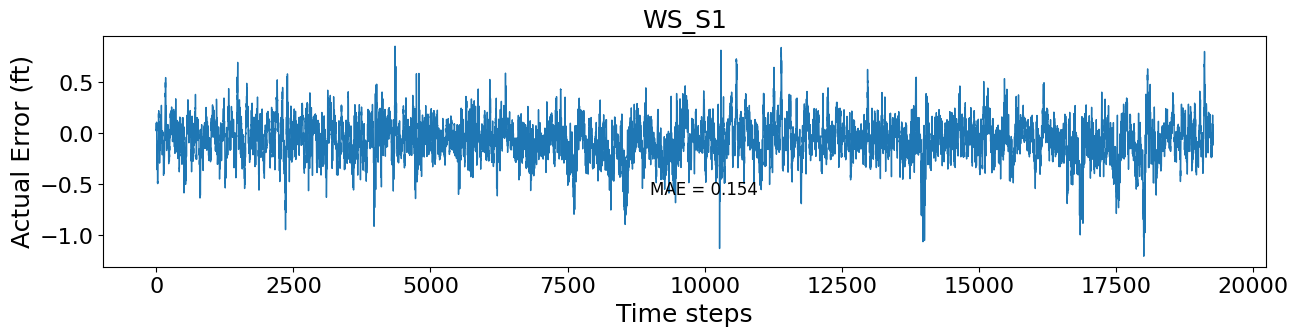

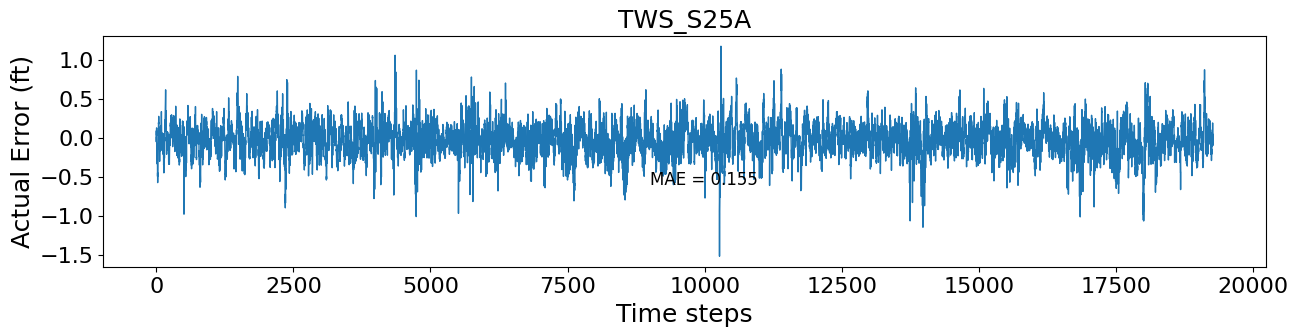

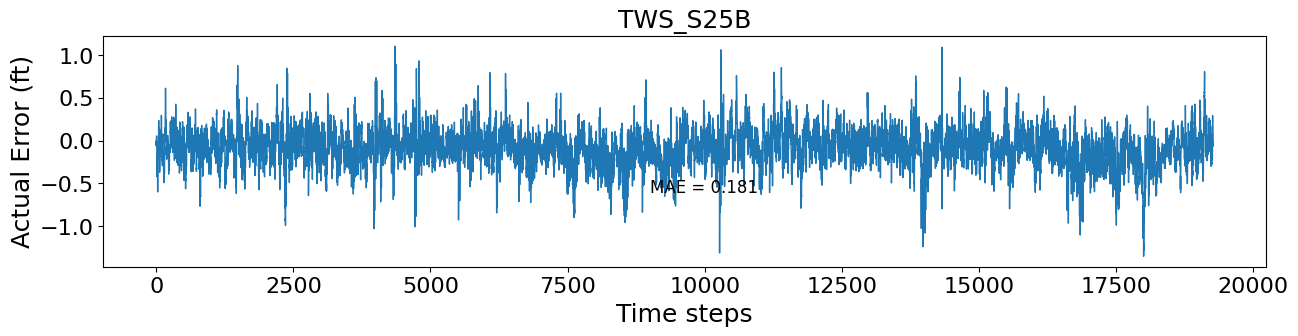

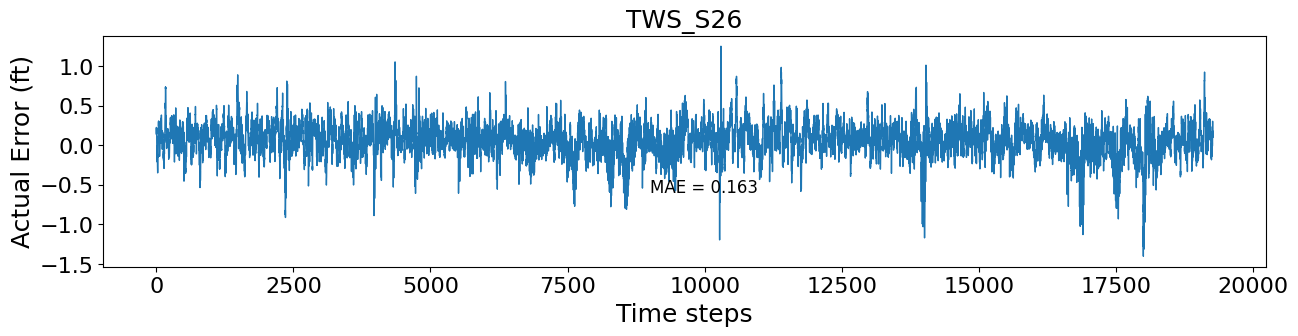

In [13]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [14]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
418
(19268,)
420
(19268,)
798
(19268,)
521


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
84
(19268,)
146
(19268,)
149
(19268,)
280


In [16]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
334
(19268,)
274
(19268,)
649
(19268,)
241
